In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

!pip install pycm

  Created wheel for pyitlib: filename=pyitlib-0.2.2-py3-none-any.whl size=28500 sha256=42421b5d8d93c515a14e7112485e4434a9ff1f43860abd4d7cca163f00e4c9c1
  Stored in directory: /root/.cache/pip/wheels/14/96/d6/86e32d66e5bb0440dc344e75849266b2bf2939520672e33e4e
Successfully built pyitlib
     |████████████████████████████████| 65 kB 2.4 MB/s 
     |████████████████████████████████| 574 kB 9.9 MB/s 


In [ ]:
import time
import os
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import interpolate
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
import scipy.sparse
import sys
import pickle
import re
from scipy import stats
from numpy import savetxt
from numpy import genfromtxt
import networkx as nx
from scipy.stats import norm
import itertools
import math
import copy
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix
from pycm import *

In [ ]:
def conditional_mutual_info(X,Y,Z=np.array(1)):
    
    if X.ndim == 1:
            X = np.reshape(X, (-1, 1))
    
    if Y.ndim == 1:
            Y = np.reshape(Y, (-1, 1))
            
    if Z.ndim == 0: 
        c1 = np.cov(X)
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
            
        c2 = np.cov(Y)
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(X,Y)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        cmi = (1/2)*np.log((d1*d2)/d3)
    
    else:
        
        if Z.ndim == 1:
            Z = np.reshape(Z, (-1, 1))
        
        c1 = np.cov(np.concatenate((X, Z), axis=0))
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
    
        c2 = np.cov(np.concatenate((Y, Z), axis=0))
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(Z)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        c4 = np.cov(np.concatenate((X, Y, Z), axis=0))
        
        if c4.ndim != 0: 
            d4 = np.linalg.det(c4)
        else:
            d4 = c4.item()
        
        cmi = (1/2)*np.log((d1*d2)/(d3*d4))
    
    
    if math.isinf(cmi):
        cmi = 0
    
    return cmi



In [ ]:
def pca_cmi(data, theta, max_order):
    
    genes = list(data.columns)
    
    predicted_graph = nx.complete_graph(genes)
    num_edges = predicted_graph.number_of_edges()
    print("Number of edges in the initial complete graph : {}".format(num_edges))
    print()
    
    L = -1
    nochange = False
    
    while L < max_order and nochange == False:
        L = L+1
        predicted_graph, nochange = remove_edges(predicted_graph, data, L, theta)
        
        print("Order : {}".format(L))
        print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))
        print()
    
    
    print()
    print()
    print("Final Prediction:")
    print("-----------------")
    print("Order : {}".format(L))
    print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))
    nx.draw(predicted_graph, with_labels=True, font_weight='bold')
    print()
    return predicted_graph


def remove_edges(predicted_graph, data, L, theta):
    
    initial_num_edges = predicted_graph.number_of_edges()
    
    edges = predicted_graph.edges()

    for edge in edges:
        neighbors = nx.common_neighbors(predicted_graph, edge[0], edge[1])
        nhbrs = copy.deepcopy(sorted(neighbors))\
        
        T = len(nhbrs)
        
        if T < L and L != 0:
            continue
        
        else:
            x = data[edge[0]].to_numpy()
            if x.ndim == 1:
                x = np.reshape(x, (-1, 1))
            
            y = data[edge[1]].to_numpy()
            if y.ndim == 1:
                y = np.reshape(y, (-1, 1))
                
            K = list(itertools.combinations(nhbrs, L))
                
            if L == 0:
                cmiVal = conditional_mutual_info(x.T, y.T)
                
                if cmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
                               
            else:  
                
                maxCmiVal = 0
                
                for zgroup in K:
                    
                    z = data[list(zgroup)].to_numpy()
                    if z.ndim == 1:
                        z = np.reshape(z, (-1, 1))
                    
                    cmiVal = conditional_mutual_info(x.T, y.T, z.T)
                    
                    if cmiVal > maxCmiVal:
                        maxCmiVal = cmiVal
                
                if maxCmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
                    
                
        
    final_num_edges = predicted_graph.number_of_edges()
        
    if final_num_edges < initial_num_edges:
        return  predicted_graph, False
        
        
    return  predicted_graph, True
            

In [ ]:
def print_theta_accuracy(standardnw_path,dataset_path):

  theta_list = [0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]
  acc_value = []
  data = pd.read_csv(dataset_path, sep='\t') 
  data = data.iloc[: , 1:]

  #getting benchmark data from file
  benchmark_network = pd.read_csv(standardnw_path, sep='\t', header=None)
  benchmark_network = benchmark_network.loc[benchmark_network[2] == 1]

  #creating benchmark graph and matrix
  benchmark_graph = nx.Graph()

  for i in (1,50):
      benchmark_graph.add_node('G'+str(i))
  print(benchmark_network.shape)
  for row in range(0,benchmark_network.shape[0]):
      benchmark_graph.add_edge(benchmark_network[0][row], benchmark_network[1][row])


  benchmark_adjMatrix = nx.adjacency_matrix(benchmark_graph)



  for i in theta_list:
    predicted_graph = pca_cmi(data, i, 10)
    predicted_adjMatrix = nx.adjacency_matrix(predicted_graph)



    y_test = benchmark_adjMatrix.todense().flatten()
    y_pred = predicted_adjMatrix.todense().flatten()

    y_pred = np.asarray(y_pred)
    y_test = np.asarray(y_test)

    y_pred = y_pred.reshape(y_pred.shape[1],)
    y_test = y_test.reshape(y_test.shape[1],)

    cm = ConfusionMatrix(y_test, y_pred)
    acc_value.append(cm.ACC_Macro)
  
  return theta_list, acc_value;



In [ ]:
directory = '/content/drive/MyDrive/673:termproject/PC-CMI_Algorithm/size50/Data/'
df_index = []
for filename in os.listdir(directory):
  if('Yeast' in filename or 'Ecoli' in filename):
    split_filename = (filename.split('-'))
  
    if(split_filename[2] in ['null','nonoise'] ):
      type = split_filename[3].split('.')
      split_mix = split_filename[2]+'-'+type[0]
    else:
      type = split_filename[2].split('.')
      split_mix = type[0]

    df_index.append(split_filename[1]+'-'+split_mix)

df_columns = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

# print(len(set(df_index)))
result_df = pd.DataFrame(columns=df_columns, index=df_index)

In [ ]:
result_df.shape

(25, 8)

/content/drive/MyDrive/673:termproject/PC-CMI_Algorithm/size50/Data/InSilicoSize50-Ecoli1-null-mutants.tsv
(62, 3)
Number of edges in the initial complete graph : 1225

Order : 0
Number of edges in the predicted graph : 243

Order : 1
Number of edges in the predicted graph : 202

Order : 2
Number of edges in the predicted graph : 147

Order : 3
Number of edges in the predicted graph : 114

Order : 4
Number of edges in the predicted graph : 113

Order : 5
Number of edges in the predicted graph : 113



Final Prediction:
-----------------
Order : 5
Number of edges in the predicted graph : 113

Number of edges in the initial complete graph : 1225

Order : 0
Number of edges in the predicted graph : 211

Order : 1
Number of edges in the predicted graph : 154

Order : 2
Number of edges in the predicted graph : 96

Order : 3
Number of edges in the predicted graph : 89

Order : 4
Number of edges in the predicted graph : 89



Final Prediction:
-----------------
Order : 4
Number of edges in the

KeyboardInterrupt: ignored

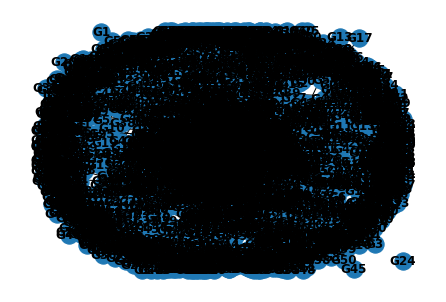

In [ ]:

directory = '/content/drive/MyDrive/673:termproject/PC-CMI_Algorithm/size50/Data/'
goldstandard_path = '/content/drive/MyDrive/673:termproject/PC-CMI_Algorithm/size50/Test/'


for filename in os.listdir(directory):
  if('Yeast' in filename or 'Ecoli' in filename):
    dataset_path = directory+filename
    split_filename = (filename.split('-'))

    if(split_filename[2] in ['null','nonoise']):
      type = split_filename[3].split('.')
      split_mix = split_filename[2]+'-'+type[0]
    else:
      type = split_filename[2].split('.')
      split_mix = type[0]

    index_location = split_filename[1]+'-'+split_mix

    goldstandard_name = ('DREAM3GoldStandard_'+split_filename[0]+'_'+split_filename[1]+'.txt')
    standardnw_path = goldstandard_path+goldstandard_name
    print(dataset_path)
    theta_list, acc_value = print_theta_accuracy(standardnw_path,dataset_path)

    for i in range(0, len(theta_list)):
      result_df[theta_list[i]][index_location] = round(acc_value[i],2)


In [ ]:
result_df

,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09
Ecoli1-null-mutants,0.8664,0.8872,0.892,0.8984,0.9048,0.908,0.912,0.912
Ecoli1-trajectories,0.8096,0.848,0.872,0.8768,0.8912,0.9032,0.904,0.9088
Ecoli1-nonoise-heterozygous,0.932,0.9352,0.9368,0.9376,0.9368,0.9408,0.9416,0.9416
Ecoli1-nonoise-proteins,0.932,0.9352,0.9368,0.9376,0.9368,0.9408,0.9416,0.9416
Ecoli1-heterozygous,0.86,0.896,0.9192,0.9328,0.94,0.9424,0.9432,0.9456
Ecoli2-nonoise-proteins,0.9112,0.9184,0.9192,0.9184,0.9208,0.9208,0.9208,0.9224
Ecoli2-nonoise-heterozygous,0.9112,0.9184,0.9192,0.9184,0.9208,0.9208,0.9208,0.9224
Ecoli2-heterozygous,0.836,0.8776,0.8992,0.9136,0.9224,0.9264,0.928,0.9288
Ecoli2-null-mutants,0.8368,0.8592,0.8744,0.8832,0.8896,0.8896,0.896,0.8976
Ecoli2-trajectories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
